<a href="https://colab.research.google.com/gist/fzimmermann89/6331868b3a42bf504c10b63c7675b05b/mri_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torchio # necessary for IXI dataset

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from typing import Tuple, Callable, Union, Optional
import h5py
from tqdm import tqdm
import torchio


In [30]:

### Fourier Transforms for k-space to image-space and vice-verse
k2i = lambda k: torch.fft.ifft2(k, norm="ortho")
i2k = lambda x: torch.fft.fft2(x, norm="ortho")

### helper functions to convert from complex numbers to '2 channel' images with a real and a complex channel
c2r = lambda x: torch.view_as_real(x).moveaxis(-1, 1)
r2c = lambda x: torch.view_as_complex(x.moveaxis(1, -1).contiguous())


In [31]:
### Simple Neural Network (UNet) ####

class ConvBlock(torch.nn.Module):
    """
    A Block of 2 Convolutions
    """
    def __init__(self, in_channels: int, mid_channels: int, out_channels: int):
        super().__init__()
        self.parts = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.parts(x)


class Unet(torch.nn.Module):
    """
    A simple Unet implementation
    """

    def __init__(self, channels: Tuple[int] = (2, 32, 48, 64, 96, 128), residual=True):
        super().__init__()
        self.blocks_enc = torch.nn.ModuleList(
            ConvBlock(channel_in, channel_out, channel_out) for channel_in, channel_out in zip(channels, channels[1:-1])
        )
        self.bottelneck = ConvBlock(channels[-2], channels[-1], channels[-2])
        self.blocks_dec = torch.nn.ModuleList(
            ConvBlock(2 * channel_in, channel_in, channel_out) for channel_in, channel_out in zip(channels[-2::-1], channels[-3::-1])
        )
        self.up = torch.nn.Upsample(scale_factor=2, mode="bilinear")
        self.down = torch.nn.MaxPool2d(2)
        self.residual = residual

    def forward(self, x: Tensor):
        res = x
        if res.is_complex():
          x = torch.view_as_real(x).moveaxis(-1, 1)
        latent = []
        for block in self.blocks_enc:
            x = block(x)
            latent.append(x)
            x = self.down(x)
        x = self.bottelneck(x)
        for z, block in zip(latent[::-1], self.blocks_dec):
            x = self.up(x)
            x = torch.cat((x, z), 1)
            x = block(x)
        if res.is_complex():
          x=torch.view_as_complex(x.moveaxis(1, -1).contiguous())
        if self.residual:
            x = x + res
        return x



In [32]:
### Reconstruction Network ###
class Combine(torch.nn.Module):
  """ 
  Combines Data and NN-Predictions by masking in k-space 
  """
  def __init__(self,i2k:Callable,k2i:Callable):
    super().__init__()
    self.i2k=i2k
    self.k2i=k2i
  def forward(self,k,mask,x_cnn):
    k_cnn = self.i2k(x_cnn)
    k = k*mask + k_cnn*(~mask)
    x = self.k2i(k)
    return x


class ReconstructionNet(torch.nn.Module):
  def __init__(self,unet:torch.nn.Module,iterations:int=2,i2k:Callable=i2k,k2i:Callable=k2i):
    super().__init__()
    self.combine = Combine(i2k,k2i)
    self.net = unet
    self.iterations = iterations
    self.k2i = k2i
  def forward(self, k, mask):
    x = self.k2i(k)
    for i in range(self.iterations):
      x_cnn = self.net(x)
      x = self.combine(k, mask, x_cnn)
    x = self.net(x)
    return x


### Conjugate Gradient Solver for Data Consistency instead of replaceing ####
def solve(mask: Tensor, i2k: Callable, k2i: Callable, k: Tensor, x_cnn: Tensor, lambda_cnn: Tensor):
    """
    Uses the conjugate gradient algorithm to solve
        argmin_x |F(x)-k|^2 + lambda_cnn*|x-x_cnn|^2
    mask: Undersampling mask
    i2k: image-to-kspace transform -> Fourier-Transform
    i2k: image-to-kspace transform -> inverse Fourier-Transform
    k: k-space data
    x_cnn: Neural network prediction
    lambda_cnn: regularisation strength

    """

    def dot(a, b):
        return torch.sum(a.conj() * b, dim=tuple(range(1, a.ndim)), keepdim=True)

    def conj_grad(H, x0, b, iterations=4):
        r = b - H(x0)
        p = r
        x = x0
        norm_r_old = dot(r, r)
        for i in range(iterations):
            loss = torch.nn.functional.mse_loss(c2r(mask * i2k(x)), c2r(mask * k)) + lambda_cnn * torch.nn.functional.mse_loss(c2r(x), c2r(x_cnn))
            d = H(p)
            alpha = norm_r_old / (dot(p, d) + 1e-12)
            x = x + p * alpha
            r = r - d * alpha
            norm_r_new = dot(r, r)
            beta = norm_r_new / norm_r_old
            p = r + beta * p
            norm_r_old = norm_r_new
        return p

    def H(x):
        return k2i(mask * i2k(x)) + lambda_cnn * x

    xi = k2i(k)
    b = lambda_cnn * x_cnn + xi
    return conj_grad(H, x_cnn, b, 4)


In [33]:
#### Dataset #####
def random_mask(N, center_n: int = 12, R: int = 2):
    """
    Creates a random undersampling mask
    center_n: low spatial-frequency k-space lines to be always present
    R: undersampling mask
    Returns a mask in fftshifted-form
    """
    mask = torch.zeros(N, dtype=bool)
    mask[: (center_n + 1) // 2] = True
    mask[-(center_n // 2) :] = True
    lines = int(N / R - center_n)
    ids = torch.multinomial(torch.ones(N - center_n), lines) + (center_n + 1) // 2
    mask[
        ids,
    ] = True
    return mask


def random_polynomial(shape: Tuple[int, int], scales: Tuple[float, ...] = (0.2, 0.1, 0.05, 0.05)):
    """
    Creates a random 2D-polynomial
    with oefficients scaled according to `scales`
    """
    random = 1 - 2 * torch.rand(len(scales), len(scales))
    coeff = random * torch.as_tensor(scales)[None, :] * torch.as_tensor(scales)[:, None]
    x = np.linspace(-1, 1, shape[0])
    y = np.linspace(-1, 1, shape[1])
    poly = np.polynomial.polynomial.polygrid2d(x, y, coeff)
    return poly


class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        path="data",
        sigma: Union[Tuple[float, float], float] = (0.001, 0.01),
        i2k: Callable = lambda x: torch.fft.fft2(x, norm="ortho"),
        R: float = 2.0,
        random_phase: bool = True
    ):
        transforms = [
            torchio.ToCanonical(),  # to RAS
            torchio.Crop((0, 0, 10, 30, 110, 40)),
            torchio.Resample((1.1, 1.1, 2.1)),
            torchio.CropOrPad((192, 192, 30)),
        ]
        self.ds = torchio.datasets.ixi.IXI(root=path, download=True, modalities=("T1",), transform=torchio.Compose(transforms))
        self.sigma = sigma
        self.i2k = i2k
        self.R = R
        self.random_phase = random_phase

    def __len__(self):
        return len(self.ds) * 10

    def __getitem__(self, idx:int):
        subject = idx // 10
        z = (idx % 10) * 3
        image = self.ds[subject].T1.data[0, ..., z] / 800
        if self.random_phase:
          phase = random_polynomial(image.shape).astype(np.float32)  # we add a random phase as our dataset is real-only
          image *= np.exp(1j * np.pi * phase)
        mask = random_mask(image.shape[1], R=self.R)[None, :]  # random undersampling mask
        if np.isscalar(self.sigma):
            sigma = self.sigma
        else:
            sigma = (self.sigma[1] - self.sigma[0]) * torch.rand(1) + self.sigma[0]
        noise = sigma * torch.randn(*image.shape) + 1j * sigma * torch.randn(*image.shape)
        k = (self.i2k(image) + noise) * mask
        return image, k, mask


# we save our dataset to an hdf5 file as colab has slow of cpus for torchio datasets...
def to_hdf5(ds, path: str, maxn: Optional[int] = None, shuffle=False):
    """
    Write a Dataset returning only Tensors to an hdf5 File
    ds: Torch Dataset
    path: save path
    maxn: quit after maxn samples
    shuffle: shuffle samples. if false, rnd is seeded to be deterministic
    """

    def wf(_):
        import torch
        import numpy
        import random

        torch.manual_seed(0)
        numpy.random.seed(0)
        random.seed(0)

    if shuffle:
        dl = torch.utils.data.DataLoader(ds, worker_init_fn=None, num_workers=4, batch_size=1, shuffle=True)
    else:
        dl = torch.utils.data.DataLoader(ds, worker_init_fn=wf, num_workers=1, batch_size=1, shuffle=False)
    with h5py.File(path, "x") as outfile:
        for i, data in tqdm(enumerate(dl)):
            if maxn is not None and i >= maxn:
                break
            for j, d in enumerate(data):
                outfile[f"/sample_{i}/value_{j}"] = np.array(d[0])
            outfile[f"/sample_{i}"].attrs["max"] = j
        outfile.attrs["max"] = i


class hdf5DS(torch.utils.data.Dataset):
    def __init__(self, path:str):
        """
        A Cached Dataset returning some tensors
        """
        self.path = path
        with h5py.File(self.path, "r") as f:
            self._len = int(f.attrs["max"])

    def __getitem__(self, idx:int):
        if idx >= self._len or idx < -self._len:
            raise IndexError("index out of range")
        i = self._len + idx if idx < 0 else idx
        ret = []
        with h5py.File(self.path, "r") as f:
            ds = f[f"/sample_{i}"]
            for j in range(ds.attrs["max"] + 1):
                d = ds[f"value_{j}"]
                ret.append(np.array(d))
        return tuple(ret)

    def __len__(self):
        return self._len


In [34]:
# we download some prepared training data to speed things up on google colab with just 2 cpu cores..
!test ! -e trainDS_R2.h5 && wget http://physik.tu-berlin.de/~zimmf/trainDS_R2.h5

In [35]:
#ds=Dataset(i2k=i2k) # create new datset
ds=hdf5DS('trainDS_R2.h5') # use prepared data set
dataloader = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, num_workers=2)

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = ReconstructionNet(Unet()).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

def L2Loss(prediction:Tensor, ground_truth:Tensor):
    """
    Returns the L2-Loss between a complex prediction and ground_truth
    """
    return torch.nn.functional.mse_loss(c2r(prediction), c2r(ground_truth))



In [ ]:
for epoch in range(35):
    runningloss = 0.
    pbar = tqdm(dataloader)
    if epoch==0:
          optimizer.param_groups[0]['lr']=3e-4 * 1/100
    for nbatch, data in enumerate(pbar):
        # move data to gpu
        ground_truth, k, mask = (i.to(device, non_blocking=True) for i in data)
        # apply our network
        x_pred = net(k,mask)
        # compare with ground truth
        loss = L2Loss(x_pred, ground_truth)
        # calculate the gradient
        loss.backward()
        # change parameters by a bi
        optimizer.step()
        # reset gradients for next time
        optimizer.zero_grad()

        # update progress bar
        l=loss.item()
        runningloss += l
        if nbatch == len(dataloader)-1:
          pbar.set_postfix_str(f'mean: {runningloss/len(dataloader)}')
        else:
          pbar.set_postfix_str(f'loss:{l:.5f} lr:{optimizer.param_groups[0]["lr"]:.2E}')

        # we increase the learning rate in the first epoch and decrease it in the last epochs
        if epoch==0:
          optimizer.param_groups[0]['lr']*=100**(1/len(dataloader))
        if epoch>15:
          optimizer.param_groups[0]['lr']*=0.9995
       

 48%|████▊     | 121/250 [00:28<00:29,  4.30it/s, loss:0.00951 lr:3.00E-04]

Text(0.5, 1.05, 'Final Result')

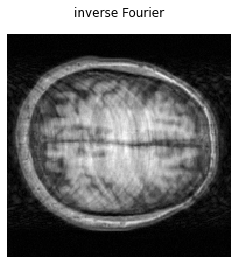

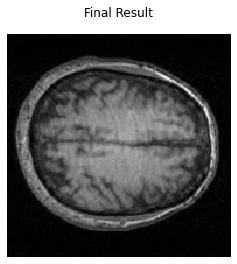

In [49]:
def plot(x):
  x=x.detach().cpu()
  plt.matshow(x.abs().numpy(),cmap='gray')
  plt.axis('off')

x0=k2i(k)
plot(x0[5])
plt.title('inverse Fourier')
plot(x_pred[5])
plt.title('Final Result')